In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

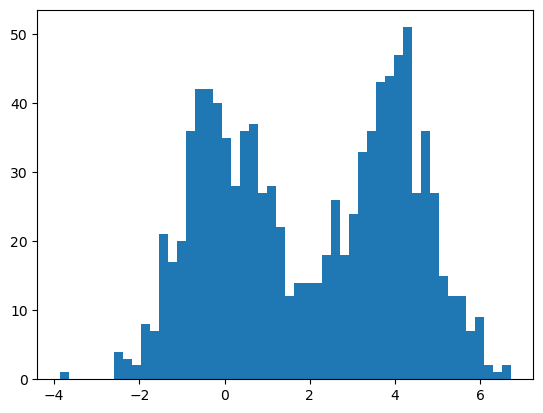

In [2]:
n = 1000
pi = 0.5

# (n, 10)
X_positive = np.random.normal(0, 1, (int(pi*n), 10))
X_negative = np.random.normal(4, 1, (int((1-pi)*n), 10))

X = np.concatenate([X_positive, X_negative], axis=0)
Y = np.concatenate([np.ones(int(pi*n)), -1 * np.ones(int((1-pi)*n))], axis=0)

# plot X - histogram of the first feature
plt.hist(X[:, 0], bins=50)
plt.show()

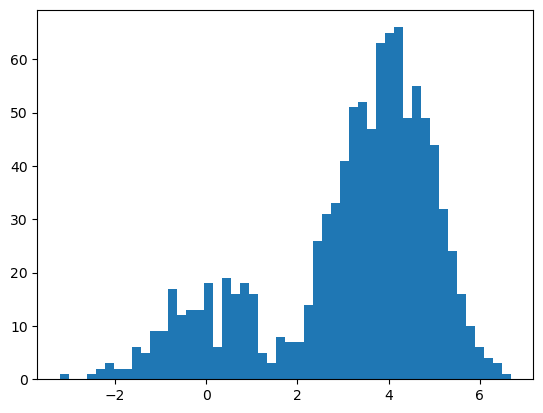

In [3]:
new_pi = 0.2

new_X_positive = np.random.normal(0, 1, (int(new_pi*n), 10))
new_X_negative = np.random.normal(4, 1, (int((1-new_pi)*n), 10))

new_X = np.concatenate([new_X_positive, new_X_negative], axis=0)
new_Y = np.concatenate([np.ones(int(new_pi*n)), -1 * np.ones(int((1-new_pi)*n))], axis=0)

# plot new_X - histogram of the first feature
plt.hist(new_X[:, 0], bins=50)
plt.show()

In [4]:
import sys
sys.path.append('./nnPUss/src/nnPUss')

from dataset import PUDatasetBase, BinaryTargetTransformer, PULabeler, SCAR_SS_Labeler
from dataset_configs import DatasetConfig
from experiment_config import ExperimentConfig
from loss import nnPUccLoss, nnPUssLoss, uPUccLoss, uPUssLoss
from run_experiment import Experiment
from MPE import KM2_estimate

In [5]:


class SyntheticPUDataset(PUDatasetBase):

    N = None
    PI = None
    MEAN = None

    def __init__(
        self,
        root,
        pu_labeler: PULabeler = None,
        target_transformer: BinaryTargetTransformer = BinaryTargetTransformer(
            included_classes=[1, -1], positive_classes=[1]
        ),
        train = True,
        download=True,  # ignored
        random_seed=None,
    ) -> None:

        assert self.N is not None
        assert self.PI is not None
        assert self.MEAN is not None

        self.root = root
        self.train = train
        self.download = download
        self.random_seed = random_seed
        self.target_transformer = target_transformer
        self.pu_labeler = pu_labeler

        self.data = torch.cat(
            [
                torch.normal(0, 1, (int(self.PI * self.N), 10)),
                torch.normal(self.MEAN, 1, (int((1 - self.PI) * self.N), 10)),
            ]
        )
        self.targets = torch.cat(
            [
                torch.ones(int(self.PI * self.N)),
                -1 * torch.ones(int((1 - self.PI) * self.N)),
            ]
        )

        self._convert_to_pu_data()

In [6]:
def create_pu_dataset_class(N, PI, PI_NEW, MEAN):
    """
    Dynamically creates a PU dataset class with given parameters.

    Args:
    - N (int): The number of samples.
    - PI (float): The proportion of class 1 samples.
    - PI_NEW (float): The new proportion of class 1 samples.
    - MEAN (float or array): The mean for the data distribution.

    Returns:
    - tuple: A tuple containing the two dynamically created classes (SyntheticPUDataset_1, SyntheticPUDataset_2).
    """
    # Define class attributes dynamically
    class_attrs_train = {
        'N': N,
        'PI': PI,
        'MEAN': MEAN
    }
    class_attrs_new = {
        'N': N,
        'PI': PI_NEW,
        'MEAN': MEAN
    }
    
    # Dynamically create the new class
    return (type('SyntheticPUDataset_1', (SyntheticPUDataset,), class_attrs_train), 
    type('SyntheticPUDataset_2', (SyntheticPUDataset,), class_attrs_new))



In [11]:


def perform_synthetic_experiment(N, PI, PI_NEW, MEAN):
    """
    Perform a synthetic experiment with the given parameters.

    Args:
    - N (int): The number of samples.
    - PI (float): The proportion of class 1 samples.
    - PI_NEW (float): The new proportion of class 1 samples.
    - MEAN (float or array): The mean for the data distribution.
    """
        
    for exp_number in range(0, 3):

        # Dynamically create the dataset classes
        SyntheticPUDataset_1, SyntheticPUDataset_2 = create_pu_dataset_class(N=N, PI=PI, PI_NEW=PI_NEW, MEAN=MEAN)

        dataset_config = DatasetConfig(
            f"Synthetic/{N}/{MEAN}/{PI}/{PI_NEW}",
            DatasetClass=SyntheticPUDataset_1,
            PULabelerClass=SCAR_SS_Labeler,
        )

        # Train the model on the first dataset
        label_frequency = 0.5
        PULoss = nnPUssLoss

        experiment_config = ExperimentConfig(
            PULoss=PULoss,
            dataset_config=dataset_config,
            label_frequency=label_frequency,
            exp_number=exp_number,
        )
        print(f"Starting: {experiment_config}...")

        experiment = Experiment(experiment_config)
        experiment.run()

        print(f"Finished: {experiment_config}")

        # Test the model on the second dataset
        new_data = SyntheticPUDataset_2(
            root = "data",
            train=True,
            pu_labeler=SCAR_SS_Labeler(label_frequency=label_frequency),
        )
        experiment.test_on_new_data(new_data)

        # Estimate the proportion of positive samples in the new dataset
        pos = new_data.data[new_data.pu_targets == 1].numpy()
        unl = new_data.data[new_data.pu_targets == -1].numpy()
        est_prior = KM2_estimate(pos, unl)
        print(f"Estimated prior: {est_prior}")

        # Adjust the model's predictions using the estimated prior
        experiment.test_on_new_data_with_new_pi(new_data, pi=SyntheticPUDataset_1.PI, est_new_pi=est_prior)

In [12]:

PI_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

n = 1000
mean = 0.5

for pi in PI_LIST:
    for pi_new in PI_LIST:
        perform_synthetic_experiment(n, pi, pi_new, mean)

Starting: Synthetic/1000/0.5/0.1/0.1, c=0.5, exp 0; nnPUss...
Epoch: 1/50
3/3 [========] - 0s 17ms/step - loss: 0.4993 - acc: 0.4910 - test_loss: 0.5112 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 2/50
3/3 [========] - 0s 17ms/step - loss: 0.4970 - acc: 0.4933 - test_loss: 0.5140 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 16ms/step - loss: 0.4943 - acc: 0.5086 - test_loss: 0.5160 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4920 - acc: 0.5139 - test_loss: 0.5173 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 5/50
3/3 [========] - 0s 16ms/step - loss: 0.4900 - acc: 0.5380 - test_loss: 0.5180 - test_accuracy: 11.1000 - pos_fraction: 0.9890
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4878 - acc: 0.5354 - test_loss: 0.5182 - test_accuracy: 14.0000 - pos_fraction: 0.9480
Epoch: 7/50
3/3 [========] - 0s 15ms/step - loss: 0.4851 - acc: 0.5425 - test_loss: 0.5179 - test_accura

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4959 - acc: 0.5095 - test_loss: 0.5085 - test_accuracy: 40.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4910 - acc: 0.5265 - test_loss: 0.5094 - test_accuracy: 39.8000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4881 - acc: 0.5473 - test_loss: 0.5099 - test_accuracy: 40.4000 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4837 - acc: 0.5601 - test_loss: 0.5101 - test_accuracy: 40.9000 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4808 - acc: 0.5814 - test_loss: 0.5098 - test_accuracy: 42.6000 - pos_fraction: 0.9260
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4779 - acc: 0.5930 - test_loss: 0.5091 - test_accuracy: 45.1000 - pos_fraction: 0.8730
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4736 - acc: 0.5995 - test_loss: 0.5079 - test_accuracy: 48.3000 - pos_fraction: 0.8090
Epoch: 10/50
3/3 [========] - 0s 24ms/s

KeyboardInterrupt: 

In [ ]:
# read the results

RESULTS_DIR = "output"
label_frequency = 0.5
N = 1000
MEAN = 0.5
TYPE = "Synthetic"
PI_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
PI_LIST = [0.1, 0.2]

results_df = pd.DataFrame(columns=["pi", "pi_new", "est_pi", "avg_accuracy", "avg_precision", "avg_recall", "avg_f1", "avg_auc",])
results = {}
for pi in PI_LIST:
    for pi_new in PI_LIST:
        for exp_number in range(0, 3):
            metrics_file_path = f"{RESULTS_DIR}/{TYPE}/{N}/{MEAN}/{pi}/{pi_new}/nnPUss/{label_frequency}/{exp_number}/new_data_metrics.json"
            with open(metrics_file_path, "r") as f:
                metrics = json.load(f)
                results[(pi, pi_new, exp_number)] = metrics

In [ ]:
os.path.join(RESULTS_DIR, "metrics.json")

In [8]:
experiment.test_on_new_data_with_new_pi(new_data, pi=0.5, new_pi=est_prior)

TypeError: Experiment.test_on_new_data_with_new_pi() got an unexpected keyword argument 'new_pi'